In [130]:
import ijson
import numpy as np
import json
from decimal import Decimal
import json
import time
import torch
import warnings
import numpy as np
from IPython.display import clear_output
import pennylane as qml

In [131]:
from sklearn.model_selection import train_test_split

In [133]:
datos = []

def cargar_datos_json(json_path, num_jets=22500, num_constituents=10):
    with open(json_path, 'r') as f:
        data = json.load(f)

    eventos = []
    for i, evento in enumerate(data[:num_jets]):
        jet_pt, jet_eta, jet_phi, jet_mass = evento['jet_kinematics']
        constituents = evento['PFCands']

        # Calcular pT para cada constituyente
        constituents = np.array(constituents)
        px = constituents[:, 0]
        py = constituents[:, 1]
        pt = np.sqrt(px**2 + py**2)

        # Índices de los 10 con mayor pT
        indices_ordenados = np.argsort(pt)[::-1][:num_constituents]
        top_cands = constituents[indices_ordenados]

        # Convertir cada uno a formato usado en el circuito
        top_constituents = []
        for cand in top_cands:
            px, py, pz, E = cand[0:4]
            d0 = cand[4]  # traversal impact parameter
            dz = cand[5]  # longitudinal impact parameter
            pt = np.sqrt(px**2 + py**2)
            p_total = np.sqrt(px**2 + py**2 + pz**2)
            eta = 0.5 * np.log((p_total + pz) / (p_total - pz + 1e-8))  # evitar división por 0
            phi = np.arctan2(py, px)
            mass = np.sqrt(np.maximum(0, E**2 - (px**2 + py**2 + pz**2)))#En caso de que de masa negativa la pone a cero
            top_constituents.append({
                'pt': pt,
                'eta': eta,
                'phi': phi,
                'mass': mass,
                'energy': E,
                'd0': d0,
                'dz': dz
            })

        eventos.append({
            'pt_jet': jet_pt,
            'eta_jet': jet_eta,
            'phi_jet': jet_phi,
            'mass_jet': jet_mass,
            'constituents': top_constituents
        })

    return eventos

#datos = cargar_datos_json('runG_batch0_reducido_22500.json')
#Para correrlo desde el mac en local
datos = cargar_datos_json('/Volumes/usb_MCarou/runG_batch0_reducido_22500.json')

In [134]:
len(datos)

22500

In [135]:
import json
import numpy as np

def cargar_datos_json(json_path, num_jets=10000, num_constituents=10):
    with open(json_path, 'r') as f:
        data = json.load(f)

    eventos = []
    for i, evento in enumerate(data[:num_jets]):
        # Extraer información del jet
        jet_pt = evento.get('jet_pt', i)
        jet_eta = evento.get('jet_eta', i)
        jet_phi = evento.get('jet_phi', i)
        jet_mass = evento.get('jet_sdmass', i)
        jet_energy = evento.get('jet_energy', i)

        # Extraer constituyentes (partículas)
        part_px = np.array(evento.get('part_px', []))
        part_py = np.array(evento.get('part_py', []))
        part_pz = np.array(evento.get('part_pz', []))
        part_energy = np.array(evento.get('part_energy', []))
        part_d0val = np.array(evento.get('part_d0val', []))
        part_dzval = np.array(evento.get('part_dzval', []))
        
        # Calcular pt, eta, phi para cada constituyente
        pt = np.sqrt(part_px**2 + part_py**2)
        p_total = np.sqrt(part_px**2 + part_py**2 + part_pz**2) 
        eta = 0.5 * np.log((p_total + part_pz) / (p_total - part_pz + 1e-8))  # Evitar división por cero
        phi = np.arctan2(part_py, part_px)
        mass = np.sqrt(np.maximum(0, part_energy**2 - (part_px**2 + part_py**2 + part_pz**2)))
        
        # Seleccionar los num_constituents con mayor pt
        indices_ordenados = np.argsort(pt)[::-1][:num_constituents]
        
        top_constituents = []
        for idx in indices_ordenados:
            top_constituents.append({
                'pt': pt[idx],
                'eta': eta[idx],
                'phi': phi[idx],
                'px': part_px[idx],
                'py': part_py[idx],
                'pz': part_pz[idx],
                'mass': mass[idx],
                'energy': part_energy[idx],
                'd0': part_d0val[idx],
                'dz': part_dzval[idx]
            })
            
        eventos.append({
            'pt_jet': jet_pt,
            'eta_jet': jet_eta,
            'phi_jet': jet_phi,
            'mass_jet': jet_mass,
            'energy_jet': jet_energy,
            'constituents': top_constituents
        })

    return eventos

# Ejemplo de uso
datos_HToBB = cargar_datos_json('/Volumes/usb_MCarou/HToBB_120.json', num_jets=10000, num_constituents=10)
datos_TTBar = cargar_datos_json('/Volumes/usb_MCarou/TTBar_120.json', num_jets=10000, num_constituents=10)
datos_WToqq = cargar_datos_json('/Volumes/usb_MCarou/WToQQ_120.json', num_jets=10000, num_constituents=10)

In [136]:
datos = np.array(datos)

# Separar 10,000 para entrenamiento y 12,500 restantes
X_train, X_temp = train_test_split(
    datos, 
    train_size=10000, 
    random_state=42, 
    shuffle=True
)

# Separar 2,500 para validación y 10,000 para inferencia
X_val, X_inf = train_test_split(
    X_temp, 
    train_size=2500, 
    random_state=42, 
    shuffle=True
)

# Verificar tamaños
print(f"Entrenamiento: {len(X_train)}")
print(f"Validación: {len(X_val)}")
print(f"Inferencia: {len(X_inf)}")

Entrenamiento: 10000
Validación: 2500
Inferencia: 10000


---
---
---
---

# **Código del paper**

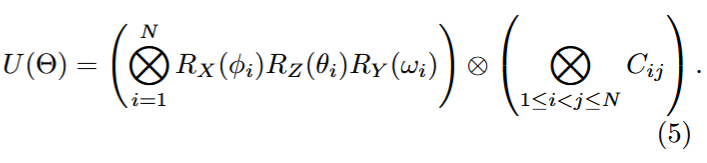

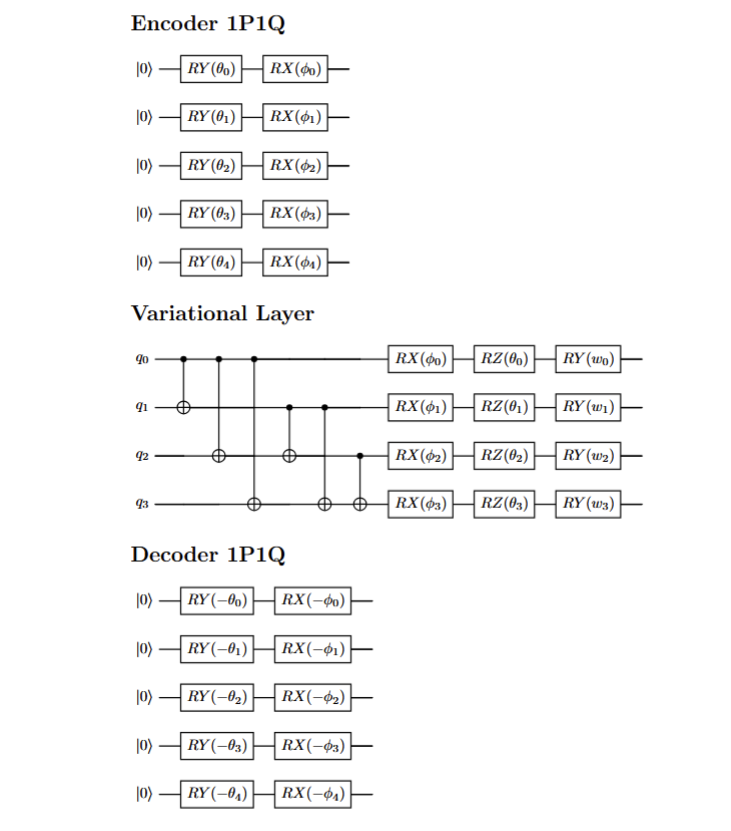

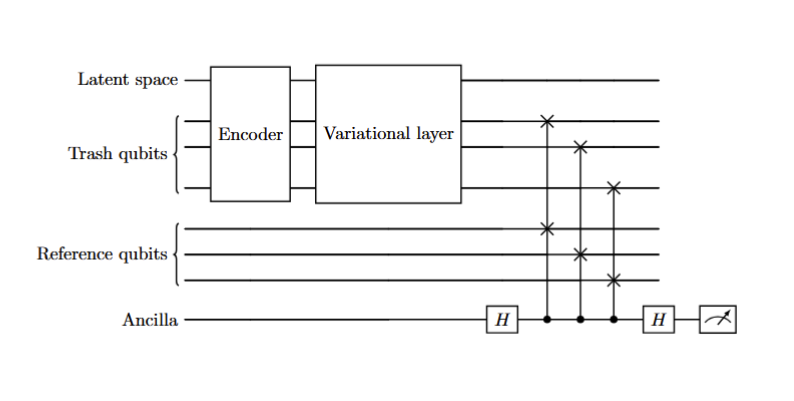

In [155]:
import pennylane as qml
import numpy as np
import torch
from scipy.linalg import expm

# Gell-Mann matrices (SU(3))
Lambda = {
    1: torch.tensor([[0, 1, 0],
                 [1, 0, 0],
                 [0, 0, 0]], dtype=torch.cdouble),

    2: torch.tensor([[0, -1j, 0],
                 [1j, 0, 0],
                 [0, 0, 0]], dtype=torch.cdouble),

    3: torch.tensor([[1, 0, 0],
                 [0, -1, 0],
                 [0, 0, 0]], dtype=torch.cdouble),

    4: torch.tensor([[0, 0, 1],
                 [0, 0, 0],
                 [1, 0, 0]], dtype=torch.cdouble),

    5: torch.tensor([[0, 0, -1j],
                 [0, 0, 0],
                 [1j, 0, 0]], dtype=torch.cdouble),

    6: torch.tensor([[0, 0, 0],
                 [0, 0, 1],
                 [0, 1, 0]], dtype=torch.cdouble),

    7: torch.tensor([[0, 0, 0],
                 [0, 0, -1j],
                 [0, 1j, 0]], dtype=torch.cdouble),

    8: (1/torch.sqrt(torch.tensor(3.0))) * torch.tensor([[1, 0, 0],
                                  [0, 1, 0],
                                  [0, 0, -2]], dtype=torch.cdouble),
    0: torch.tensor([[1, 0, 0],
                 [0, 1, 0],
                 [0, 0, 1]], dtype=torch.cdouble)
}

# Spin-1 rotation generators (SO(3) ⊂ SU(3))
Sigma = {
    1: (1 / torch.sqrt(torch.tensor(2.0))) * torch.tensor([
        [0, 1, 0],
        [1, 0, 1],
        [0, 1, 0]
    ], dtype=torch.cdouble),

    2: (1 / torch.sqrt(torch.tensor(2.0))) * torch.tensor([
        [0, -1j, 0],
        [1j, 0, -1j],
        [0, 1j, 0]
    ], dtype=torch.cdouble),

    3: torch.tensor([
        [1, 0, 0],
        [0, 0, 0],
        [0, 0, -1]
    ], dtype=torch.cdouble)
}

def TSWAP_matrix():
    tswap = np.zeros((9, 9), dtype=complex)
    for i in range(3):
        for j in range(3):
            ket = np.zeros(9)
            bra = np.zeros(9)
            ket[3*i + j] = 1   # |i⟩|j⟩
            bra[3*j + i] = 1   # |j⟩|i⟩
            tswap += np.outer(bra, ket)
    return tswap


def unitary_from_generator(generator_matrix, theta):
    if not torch.is_tensor(theta):
        theta = torch.tensor(theta, dtype=torch.cdouble)
    i = torch.tensor(1j, dtype=torch.cdouble)
    return Lambda[0] + (torch.cos(theta) - torch.tensor(1.0)) * generator_matrix @ generator_matrix + i * torch.sin(theta) * generator_matrix

def inicializing_qutrit_state(theta1, theta2, phi1, phi2):
    Gamma= 0
    a0 = 0
    a1 = 0
    a2 = 0

    Gamma = torch.sqrt(torch.tensor(2.0)) * (torch.tensor(3.0) + torch.cos(theta1)*torch.cos(theta2) + torch.sin(theta1)*torch.sin(theta2)*torch.cos(phi1 - phi2))**(torch.tensor(-0.5))

    a0 = (torch.sqrt(torch.tensor(2.0)) * torch.cos(theta1/2) * torch.cos(theta2/2)).item()
    a1 = (torch.exp(1j * phi1) * torch.sin(theta1/2) * torch.sin(theta2/2) + torch.cos(theta1/2) * torch.sin(theta2/2) * torch.exp(1j * phi2)).item()
    a2 = (torch.sqrt(torch.tensor(2.0)) * torch.exp(1j * (phi1 + phi2)) * torch.sin(theta1/2) * torch.sin(theta2/2)).item()

    state = Gamma * torch.tensor([a0, a1, a2], dtype=torch.cdouble)
    state = state / torch.linalg.norm(state)
    
    

    return state.detach().clone().numpy()

import numpy as np
from scipy.linalg import qr

def unitary_from_state(psi):
    """
    psi: vector complejo normalizado de dimension 3 (qutrit)
    retorna: unitaria 3x3 cuyo primer columna es psi
    """
    psi = psi / np.linalg.norm(psi)  # por seguridad
    
    a1 = torch.tensor([0.555,0, 0.555], dtype=torch.cdouble)
    a2 = torch.tensor([0.555,0.555, 0], dtype=torch.cdouble)
    mat = np.column_stack([psi, a1 , a2])

    Q, R = qr(mat)
    phase = np.vdot(psi, Q[:,0])
    Q[:,0] = Q[:,0] * (phase/abs(phase)).conj()
    
    return Q



In [284]:
# --- Parámetros del circuito ---
num_particles = 4
num_latent = 1
num_ref = num_particles - num_latent
num_trash = num_ref
wires = list(range(num_particles + num_ref + 1))  # +1 ancilla
ancilla = wires[-1]
dev = qml.device("default.qutrit", wires=wires)  # Cambiado a qutrits

latent_wire = 0
trash_wires = wires[1:num_particles]
ref_wires = wires[num_particles:-1]

# --- Funciones de codificación ---
def f(w): return 1 + (2 * np.pi / (1 + torch.exp(-w)))
def phi_circuit(w, phi, phi_jet, pt, pt_jet): return f(w) * (pt / pt_jet) * (phi - phi_jet)
def theta_circuit(w, eta, eta_jet, pt, pt_jet): return f(w) * (pt / pt_jet) * (eta - eta_jet)
def mass_circuit(w, mass, mass_jet, pt, pt_jet):  return  f(w) * (pt / pt_jet) * (mass - mass_jet)
def energy_circuit(w, energy, pt, pt_jet): return f(w) * (pt / pt_jet) *  (energy)
def d0_circuit(w, d0, pt, pt_jet): return f(w) * (pt / pt_jet) * (d0)
def dz_circuit(w, dz, pt, pt_jet): return f(w) * (pt / pt_jet) * (dz)

# --- Encoder aproximado para qutrits ---
def encode_1p1q_qutrit(jets, w):
    pt_jet = jets['pt_jet']
    eta_jet = jets['eta_jet']
    phi_jet = jets['phi_jet']
    mass_jet = jets['mass_jet']
    constituents = jets['constituents']
        
    for i in range(num_particles):
        c = constituents[i]
        theta = theta_circuit(w, c['eta'], eta_jet, c['pt'], pt_jet)
        phi = phi_circuit(w, c['phi'], phi_jet, c['pt'], pt_jet)
        mass = mass_circuit(w, c['mass'], mass_jet, c['pt'], pt_jet)
        energy = energy_circuit(w, c['energy'], c['pt'], pt_jet)
        d0 = d0_circuit(w, c['d0'], c['pt'], pt_jet)
        dz = dz_circuit(w, c['dz'], c['pt'], pt_jet)

        initial_state = inicializing_qutrit_state(theta, phi, mass, energy)
        u = unitary_from_state(initial_state)
        qml.QutritUnitary(u, wires=i)
        

# --- Variational layer para qutrits ---
def variational_layer_qutrit(theta_i, phi_i, w_i, num_layers):
    for layer in range(num_layers):
        for i in range(num_particles):
            for j in range(i + 1, num_particles):
                qml.TAdd(wires=[i, j])
        for i in range(num_particles):

            RX = unitary_from_generator(Sigma[1], phi_i[layer, i])
            RY = unitary_from_generator(Sigma[2], theta_i[layer, i])
            RZ = unitary_from_generator(Sigma[3], w_i[layer, i])
    
            qml.QutritUnitary(RX, wires=i)
            qml.QutritUnitary(RZ, wires=i)
            qml.QutritUnitary(RY, wires=i)

# --- QAE Circuit con qutrits ---
@qml.qnode(dev, interface="torch", diff_method="backprop")
def qae_circuit_qutrit(jets, w, theta_i, phi_i, w_i, num_layers):
    encode_1p1q_qutrit(jets, w)
    variational_layer_qutrit(theta_i, phi_i, w_i, num_layers)
    tswap = TSWAP_matrix()

    for trash_wire, ref_wire in zip(trash_wires, ref_wires):
        qml.THadamard(wires=ancilla, subspace=None) #With none they apply the generalized version
        qml.ControlledQutritUnitary(tswap, control_wires=ancilla, wires=[trash_wire, ref_wire])
        qml.THadamard(wires=ancilla, subspace=None)
    
    return qml.probs(wires=ancilla)

# --- Función de costo ---
def cost_function_with_fidelity_qutrit(jet, w, theta_i, phi_i, w_i, num_layers):
    prob_0 = qae_circuit_qutrit(jet, w, theta_i, phi_i, w_i, num_layers)[0]
    fidelity = prob_0
    return -fidelity, fidelity.item()

In [140]:
#from qiskit.visualization import array_to_latex

tswap = TSWAP_matrix()
#latex_code = array_to_latex(np.real(tswap).astype(int), prefix="\\text{TSWAP} = ")
#display(latex_code)

In [311]:
# --- Entrenamiento y evaluación unificados ---
w = torch.tensor(1.0, requires_grad=True)
num_layers = 5 # Número de capas variacionales
theta_i = (torch.rand(num_layers, num_particles) * 2 * torch.pi).requires_grad_(True)
phi_i   = (torch.rand(num_layers, num_particles) * 2 * torch.pi).requires_grad_(True)
w_i     = (torch.rand(num_layers, num_particles) * 2 * torch.pi).requires_grad_(True)
optimizer = torch.optim.Adam(
    [w, theta_i, phi_i, w_i],
    lr=5e-2,              
    betas=(0.5, 0.999),
    eps=1e-08,
    weight_decay=0.0,    
    amsgrad=True          
)
num_epochs = 1
all_fidelities = []
event_fidelities = []  # Lista para almacenar fidelidades por evento

inicio = time.time()
# --- Entrenamiento ---
for epoch in range(num_epochs):
    total_loss = 0.0
    epoch_fidelities = []
    avg_fidelity = 0.0
    avg_loss = 0.0
    
    for jet in X_train:
        if len(jet['constituents']) < num_particles:
            continue
    
        loss, fidelity = cost_function_with_fidelity_qutrit(jet, w, theta_i, phi_i, w_i,  num_layers)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        epoch_fidelities.append(fidelity)
        event_fidelities.append(fidelity * 100)  # en %

    avg_loss = total_loss / len(epoch_fidelities)
    avg_fidelity = np.mean(epoch_fidelities) * 100
    all_fidelities.append(avg_fidelity)
    
    print(f"Epoch {epoch+1}, Loss: {1 + avg_loss:.4f}, Avg Fidelity: {avg_fidelity:.2f}%")

end = time.time()

tiempo_entrenamiento = (end - inicio)/ 60
print("Tiempo transcurrido: ", tiempo_entrenamiento)

Epoch 1, Loss: 0.0155, Avg Fidelity: 98.45%
Tiempo transcurrido:  4.850378084182739


In [298]:
print("Tiempo transcurrido: ", tiempo_entrenamiento)
print("Fidelidades: ", all_fidelities[0])

Tiempo transcurrido:  6.938561300436656
Fidelidades:  98.70656761088469


In [312]:
import matplotlib.pyplot as plt

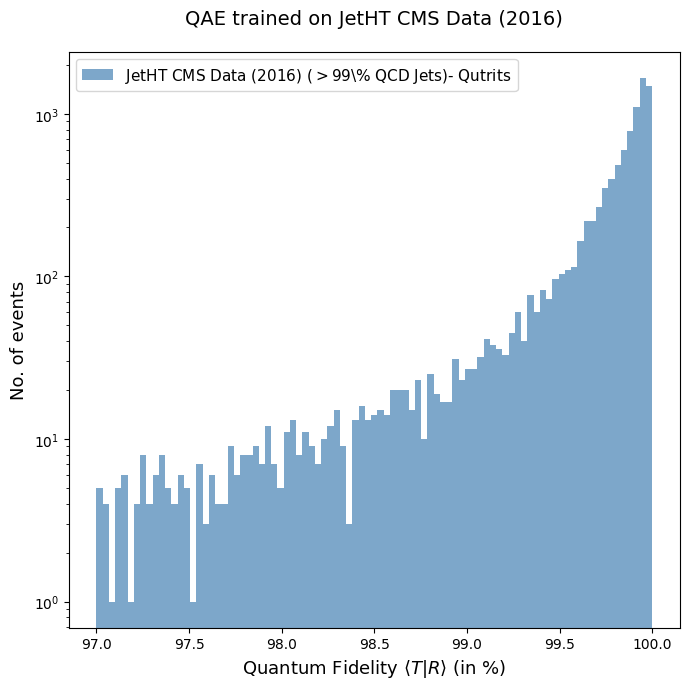

In [313]:
bins = np.linspace(97, 100, 90)

plt.figure(figsize=(7, 7))
plt.hist(event_fidelities, bins=bins, histtype='stepfilled',
         color='steelblue', alpha=0.7, label=r'JetHT CMS Data (2016) ($>$99\% QCD Jets)- Qutrits')
plt.yscale('log')
plt.xlabel(r'Quantum Fidelity $\langle T|R \rangle$ (in %)', fontsize=13)
plt.ylabel(r'No. of events', fontsize=13)
plt.legend(loc='upper left', fontsize=11)
plt.title(r'QAE trained on JetHT CMS Data (2016)', fontsize=14, pad=20)
plt.tight_layout()
plt.savefig("entrenamiento_mE_5l.png", dpi=300, bbox_inches='tight')
plt.show()

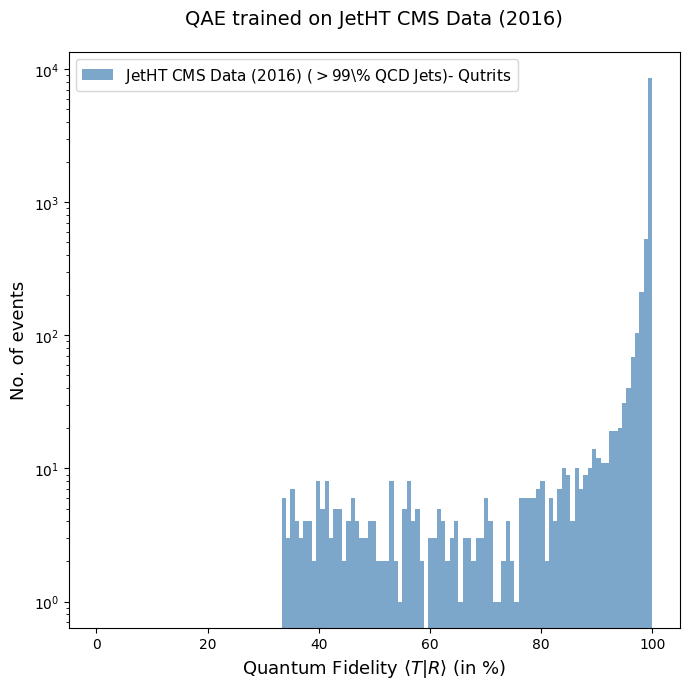

In [315]:
bins = np.linspace(0, 100, 130)

plt.figure(figsize=(7, 7))
plt.hist(event_fidelities, bins=bins, histtype='stepfilled',
         color='steelblue', alpha=0.7, label=r'JetHT CMS Data (2016) ($>$99\% QCD Jets)- Qutrits')
plt.yscale('log')
plt.xlabel(r'Quantum Fidelity $\langle T|R \rangle$ (in %)', fontsize=13)
plt.ylabel(r'No. of events', fontsize=13)
plt.legend(loc='upper left', fontsize=11)
plt.title(r'QAE trained on JetHT CMS Data (2016)', fontsize=14, pad=20)
plt.tight_layout()
plt.savefig("entrenamiento_mE_5l_full.png", dpi=300, bbox_inches='tight')
plt.show()

In [303]:
from sklearn.metrics import roc_auc_score

event_fidelities_back = []
event_fidelities_HToBB = []
event_fidelities_WToQQ = []
event_fidelities_TTBar = []
fidelidades = []
etiquetas = []

inicio = time.time()
for jet in X_inf:
    if len(jet['constituents']) < num_particles:
        continue
    _, fidelity = cost_function_with_fidelity_qutrit(jet, w, theta_i, phi_i, w_i, num_layers)
    event_fidelities_back.append(fidelity * 100) 
    fidelidades.append(fidelity)
    etiquetas.append(0)

end = time.time()
print("Terminada prueba de validación")
tiempo_test = (end - inicio)/ 60
print("Tiempo transcurrido: ", tiempo_test)

inicio = time.time()
for jet in datos_HToBB:
    if len(jet['constituents']) < num_particles:
        continue
    _, fidelity = cost_function_with_fidelity_qutrit(jet, w, theta_i, phi_i, w_i, num_layers)
    event_fidelities_HToBB.append(fidelity * 100) 
    fidelidades.append(fidelity)
    etiquetas.append(1)

print("Terminada prueba con HToBB")

for jet in datos_TTBar:
    if len(jet['constituents']) < num_particles:
        continue
    _, fidelity = cost_function_with_fidelity_qutrit(jet, w, theta_i, phi_i, w_i, num_layers)
    event_fidelities_TTBar.append(fidelity * 100) 
    fidelidades.append(fidelity)
    etiquetas.append(1)

print("Terminada prueba con TTBar")

for jet in datos_WToqq:
    if len(jet['constituents']) < num_particles:
        continue
    _, fidelity = cost_function_with_fidelity_qutrit(jet, w, theta_i, phi_i, w_i, num_layers)
    event_fidelities_WToQQ.append(fidelity * 100) 
    fidelidades.append(fidelity)
    etiquetas.append(1)

print("Terminada prueba con WToqq")
end = time.time()
tiempo_inf = (end - inicio)/ 60
print("Tiempo transcurrido: ", tiempo_inf)

Terminada prueba de validación
Tiempo transcurrido:  1.5732433358828226
Terminada prueba con HToBB
Terminada prueba con TTBar
Terminada prueba con WToqq
Tiempo transcurrido:  3.3884581685066224


In [309]:
print("Tiempo transcurrido: ", tiempo_inf)
print("Fidelidades HToBB: ", event_fidelities_HToBB[-1])
print("Fidelidades WToQQ: ", event_fidelities_WToQQ[-1])
print("Fidelidades TTBar: ", event_fidelities_TTBar[-1])

Tiempo transcurrido:  3.3884581685066224
Fidelidades HToBB:  99.56255666041908
Fidelidades WToQQ:  99.9706398692452
Fidelidades TTBar:  99.95584709649366


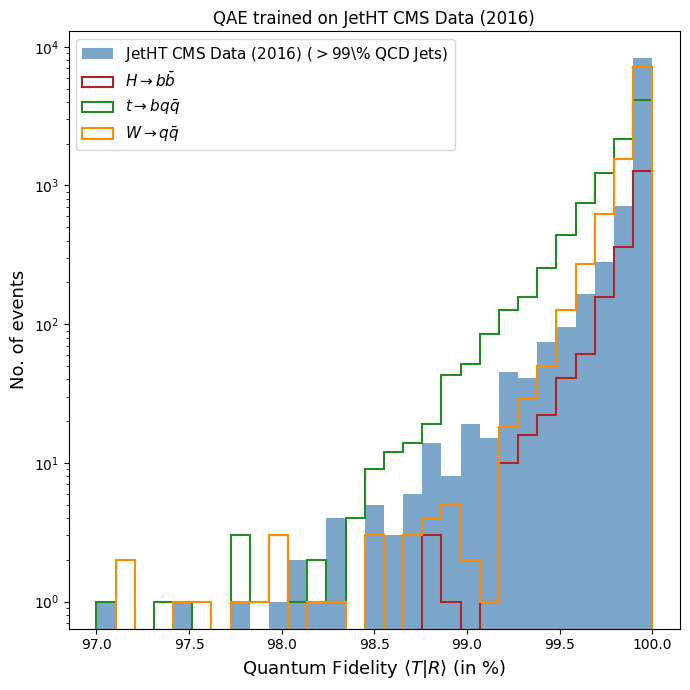

In [305]:
plt.figure(figsize=(7, 7))

# Definir bins (de 97 a 100, como en la referencia)
bins = np.linspace(97, 100, 30)

# --- Background: relleno azul ---
plt.hist(event_fidelities_back, 
         bins=bins, 
         histtype='stepfilled', 
         color='steelblue', 
         alpha=0.7, 
         label=r'JetHT CMS Data (2016) ($>$99\% QCD Jets)')

# --- H → bb : línea roja discontinua ---
plt.hist(event_fidelities_HToBB, 
         bins=bins, 
         histtype='step', 
         color='firebrick', 
         linewidth=1.5, 
         linestyle='-', 
         label=r'$H \rightarrow b\bar{b}$')

# --- t → bqq : línea verde punteada ---
plt.hist(event_fidelities_TTBar, 
         bins=bins, 
         histtype='step', 
         color='forestgreen', 
         linewidth=1.5, 
         linestyle='-', 
         label=r'$t \rightarrow bq\bar{q}$')

# --- W → qq : línea naranja punteada ---
plt.hist(event_fidelities_WToQQ, 
         bins=bins, 
         histtype='step', 
         color='darkorange', 
         linewidth=1.5, 
         linestyle='-', 
         label=r'$W \rightarrow q\bar{q}$')


plt.yscale('log')
plt.xlabel(r'Quantum Fidelity $\langle T|R \rangle$ (in %)', fontsize=13)
plt.ylabel(r'No. of events', fontsize=13)
plt.title(r'QAE trained on JetHT CMS Data (2016)', fontsize=12, pad=5)
plt.legend(loc='upper left', fontsize=11)
plt.tight_layout()
plt.savefig("test_mE_3epochs_2l.png", dpi=300, bbox_inches='tight')
plt.show()

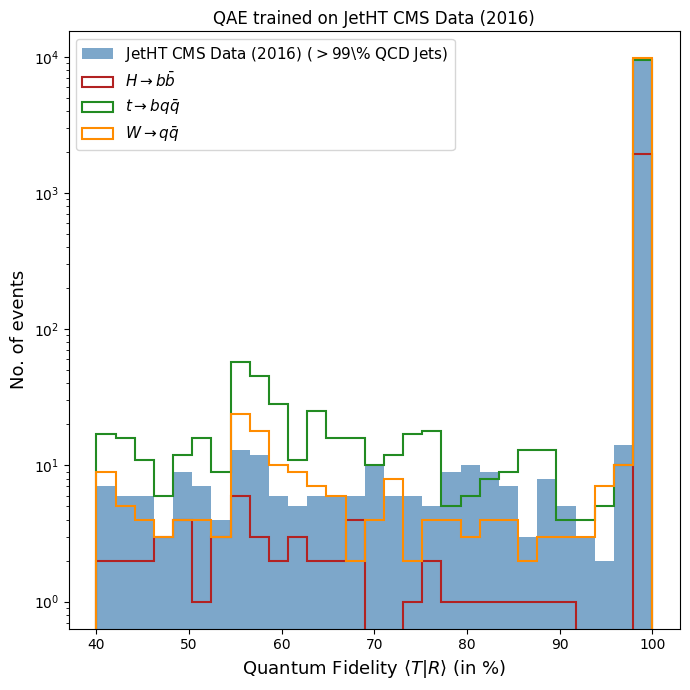

In [306]:
plt.figure(figsize=(7, 7))

# Definir bins (de 97 a 100, como en la referencia)
bins = np.linspace(40, 100, 30)

# --- Background: relleno azul ---
plt.hist(event_fidelities_back, 
         bins=bins, 
         histtype='stepfilled', 
         color='steelblue', 
         alpha=0.7, 
         label=r'JetHT CMS Data (2016) ($>$99\% QCD Jets)')

# --- H → bb : línea roja discontinua ---
plt.hist(event_fidelities_HToBB, 
         bins=bins, 
         histtype='step', 
         color='firebrick', 
         linewidth=1.5, 
         linestyle='-', 
         label=r'$H \rightarrow b\bar{b}$')

# --- t → bqq : línea verde punteada ---
plt.hist(event_fidelities_TTBar, 
         bins=bins, 
         histtype='step', 
         color='forestgreen', 
         linewidth=1.5, 
         linestyle='-', 
         label=r'$t \rightarrow bq\bar{q}$')

# --- W → qq : línea naranja punteada ---
plt.hist(event_fidelities_WToQQ, 
         bins=bins, 
         histtype='step', 
         color='darkorange', 
         linewidth=1.5, 
         linestyle='-', 
         label=r'$W \rightarrow q\bar{q}$')


plt.yscale('log')
plt.xlabel(r'Quantum Fidelity $\langle T|R \rangle$ (in %)', fontsize=13)
plt.ylabel(r'No. of events', fontsize=13)
plt.title(r'QAE trained on JetHT CMS Data (2016)', fontsize=12, pad=5)
plt.legend(loc='upper left', fontsize=11)
plt.tight_layout()
plt.savefig("test_mE_3epochs_2l_full.png", dpi=300, bbox_inches='tight')
plt.show()

AUC (QCD vs H→bb): 0.6946
AUC (QCD vs t→bqq): 0.8002
AUC (QCD vs W→qq): 0.6532


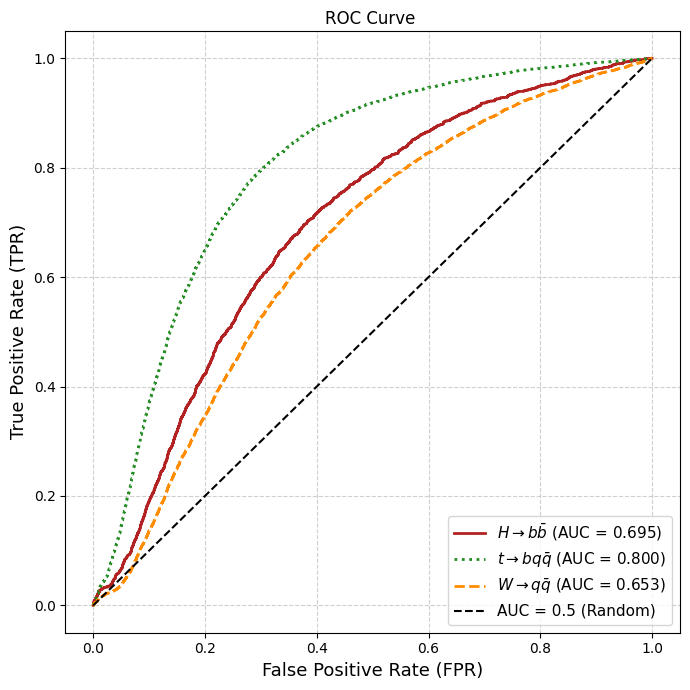

In [307]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

# --- Anomaly scores (1 - Fidelity) ---
anomaly_scores_back = 1 - np.array(event_fidelities_back)
anomaly_scores_HToBB = 1 - np.array(event_fidelities_HToBB)
anomaly_scores_TTBar = 1 - np.array(event_fidelities_TTBar)
anomaly_scores_WToQQ = 1 - np.array(event_fidelities_WToQQ)

# --- Calcular AUC ---
auc_HToBB = roc_auc_score(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_HToBB)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_HToBB])
)

auc_TTBar = roc_auc_score(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_TTBar)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_TTBar])
)

auc_WToQQ = roc_auc_score(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_WToQQ)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_WToQQ])
)

print(f"AUC (QCD vs H→bb): {auc_HToBB:.4f}")
print(f"AUC (QCD vs t→bqq): {auc_TTBar:.4f}")
print(f"AUC (QCD vs W→qq): {auc_WToQQ:.4f}")

# --- Graficar curvas ROC ---
plt.figure(figsize=(7, 7))

# H→bb
fpr_HToBB, tpr_HToBB, _ = roc_curve(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_HToBB)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_HToBB])
)
plt.plot(fpr_HToBB, tpr_HToBB, color='firebrick', linewidth=2,
         label=rf'$H \rightarrow b\bar{{b}}$ (AUC = {auc_HToBB:.3f})')

# t→bqq
fpr_TTBar, tpr_TTBar, _ = roc_curve(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_TTBar)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_TTBar])
)
plt.plot(fpr_TTBar, tpr_TTBar, color='forestgreen', linewidth=2, linestyle=':',
         label=rf'$t \rightarrow bq\bar{{q}}$ (AUC = {auc_TTBar:.3f})')

# W→qq
fpr_WToQQ, tpr_WToQQ, _ = roc_curve(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_WToQQ)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_WToQQ])
)
plt.plot(fpr_WToQQ, tpr_WToQQ, color='darkorange', linewidth=2, linestyle='--',
         label=rf'$W \rightarrow q\bar{{q}}$ (AUC = {auc_WToQQ:.3f})')

# Línea aleatoria (AUC = 0.5)
plt.plot([0, 1], [0, 1], 'k--', label=r'AUC = 0.5 (Random)')

# --- Personalización ejes y leyenda ---
plt.xlabel(r'False Positive Rate (FPR)', fontsize=13)
plt.ylabel(r'True Positive Rate (TPR)', fontsize=13)
plt.title(r'ROC Curve ', fontsize=12, pad=5)
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)

# Ajuste márgenes y guardado
plt.tight_layout()
plt.savefig("metricas_mE_3epochs_2l.png", dpi=300, bbox_inches='tight')
plt.show()
